In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt

In [2]:
df_train = pd.read_csv('data/PHOENIX-2014-T.train.corpus.csv', sep='|')
df_train.drop(columns=['name','video','start','end','speaker'], inplace = True)
train_size = df_train.shape[0]

df_val = pd.read_csv('data/PHOENIX-2014-T.dev.corpus.csv', sep = '|')
df_val.drop(columns = ['name', 'video', 'start', 'end', 'speaker'], inplace = True)
val_size = df_val.shape[0]

df_test = pd.read_csv('data/PHOENIX-2014-T.test.corpus.csv', sep = '|')
df_test.drop(columns = ['name', 'video', 'start', 'end', 'speaker'], inplace = True)
test_size = df_test.shape[0]

In [3]:
print(df_train.shape)
print(df_val.shape)
print(df_test.shape)

(7096, 2)
(519, 2)
(642, 2)


### Primeri

Primeri originalne recenice i prevoda. Nemacki tekst ce nam biti original, koji cemo da prevodimo na glosseve.


In [4]:
df_train.iloc[1]['translation']

'mancherorts regnet es auch länger und ergiebig auch lokale überschwemmungen sind wieder möglich'

Negde ce padati kisa i duze, lokalne poplave su takodje ponovo moguce.

In [5]:
df_train.iloc[1]['orth']

'ORT REGEN DURCH REGEN KOENNEN UEBERSCHWEMMUNG KOENNEN'

Vidimo iz primera da u glossevima nedostaju nemacki umlaut karakteri: Ä,Ö i Ü. Reci KOENNEN I UEBERSCHWEMMUNG se pravilno pisu KÖNNEN i ÜBERSCHWEMMUNG.

In [6]:
input_texts = df_train['translation']
target_texts = df_train['orth']

In [7]:
umlaut_dict = {'AE': 'Ä',
               'OE': 'Ö',
               'UE': 'Ü',
               'AÜ': 'AUE'}

U nemackom je 'AUE' cesta kombinacija karaktera, pa smo je oznacili kao specijalan slucaj gde ne treba umlaut da se stavi.

In [8]:
for key in umlaut_dict.keys():
    target_texts = [text.replace(key, umlaut_dict[key]) for text in target_texts]

Na vise mesta medju glossevima crta spaja dva glossa, da bi model bolje obradjivao ovakve slucajeve, odvojicemo crtu od reci koje spaja i tretirati je kao poseban token.

In [9]:
target_texts = [text.replace('-', ' - ') for text in target_texts]

Dalje cemo da izdvojimo najcesce reci iz originalnih tekstova i prevoda.

In [10]:
d_input = {}
for s in input_texts:
    words = s.split(' ')
    for w in words:
        if w in d_input.keys():
            d_input[w]+= 1
        else:
            d_input[w] = 1
sd_input = sorted(d_input, key=d_input.get)
sd_input.reverse()
print("Unique words: ",len(sd_input),", Total words: ",sum(d_input.values()))

Unique words:  2887 , Total words:  99081


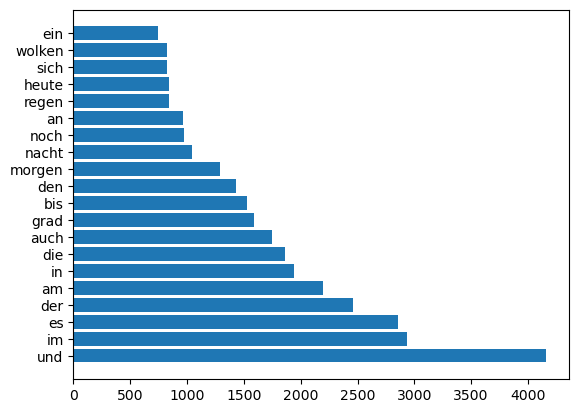

In [11]:
plt.barh(sd_input[:20], [d_input[w] for w in sd_input[:20]])
plt.show()

Kao sto je ocekivano, najcesce reci u nemackom su veznici, clanovi i predlozi. Medju izuzecima se izdvajaju reci 'grad', 'morgen', 'nacht', 'regen' i 'wolken', koje redom znace 'stepeni', 'jutro', 'noc', 'kisa' i 'oblaci', sto nije iznenadjujuce, s obizrom da je baza iz vremenske prognoze.

In [12]:
d_target = {}
for s in target_texts:
    words = s.split(' ')
    for w in words:
        if w in d_target.keys():
            d_target[w]+= 1
        else:
            d_target[w] = 1
sd_target = sorted(d_target, key=d_target.get)
sd_target.reverse()
print("Unique words: ",len(sd_target),", Total words: ",sum(d_target.values()))

Unique words:  975 , Total words:  58469


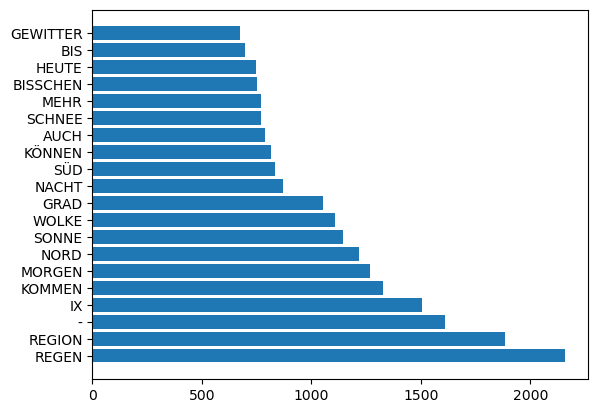

In [13]:
plt.barh(sd_target[:20], [d_target[w] for w in sd_target[:20]])
plt.show()

Posto glossevi prirodno izostavljaju vecinu stop reci, jasnije se vidi da je tekst o vremenskoj prognozi. Ovde se izdvajaju  2 tokena: 'IX' i '-'. 'IX' oznacava 'index' i koristi se kao znak pokazivanje i indeksiranja ili lokacije ili osobe koja ce kasnije da se koristi u recenici, nesto kao zamenica.

Dalje cemo da ucitamo pretrenirane 'glove' embeddinge i izdvojiti reci iz orginala i prevoda koji nemaju odgovarajuci embedding, odnosno reci van vokabulara.

In [14]:
embedding_size = 300

input_word_embeddings = {}
target_word_embeddings = {}
with open('glove-embedding/vectors.txt', 'r', encoding = 'utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype = 'float32')
        input_word_embeddings[word] = coefs
        target_word_embeddings[word.upper()] = coefs

In [15]:
oov_words_input = []
for word in sd_input:
    if not word in input_word_embeddings:
        oov_words_input.append(word)
print('Broj reci bez embeddinga u originalnim nemackim tekstovima: ', len(oov_words_input))

Broj reci bez embeddinga u originalnim nemackim tekstovima:  270


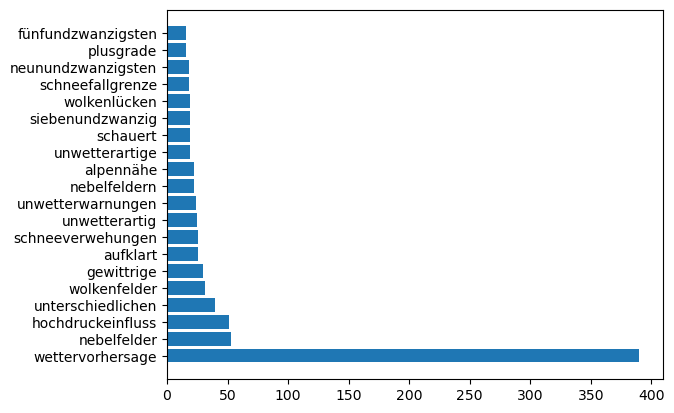

In [16]:
plt.barh(oov_words_input[:20], [d_input[w] for w in oov_words_input[:20]])
plt.show()

Vecinski su reci nemacke slozenice, najcesca 'wettervorhersage' je vremenska prognoza. Za ovaj problem ne postoji jednostavno resenje. 

In [18]:
oov_words_target = []
for word in sd_target:
    if not word in target_word_embeddings:
        oov_words_target.append(word)
print('Broj glosseva bez embeddinga: ', len(oov_words_target))

Broj glosseva bez embeddinga:  65


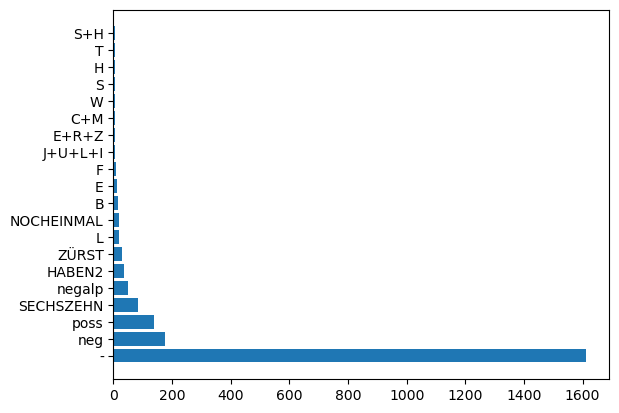

In [19]:
plt.barh(oov_words_target[:20], [d_target[w] for w in oov_words_target[:20]])
plt.show()

Plusevi oznacavaju fingerspelling - pokazivanje reci slovo po slovo, ali su dosta retki, pa cemo ovo da ignorisemo. Vidimo da se ovde pojavljuje i '-', koju smo namenski uveli kao token. Zanimljivi su 'negalp', 'poss' i 'neg', koji predstavljaju posebne semanticke elemente znakovnog jezika.